## **(Virtual Adversarial Training) VAT**

#### **Loss function**

- loss function은 perturbation이 적용된 input을 모델에 넣었을 떄의 output과 perturbation이 적용되지 않은 input을 모델에 넣었을 때의 output간의 KL divergence로 구하게 됩니다.
- 또한 label이 있는 이미지에 대해서는 cross entropy loss를 이용하고 있습니다.

In [1]:
import sys
sys.path.append(".")
import argparse
from torchvision import datasets, transforms
import pandas as pd
import torch.optim as optim
from model import *
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 4]
import os
import json

- 기본적인 설정값을 지정

In [2]:
batch_size = 32
eval_batch_size = 100
unlabeled_batch_size = 128
num_labeled = 1000
num_valid = 1000
num_iter_per_epoch = 400
eval_freq = 5
lr = 0.001
cuda_device = "0"

- arguments 지정

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', default = 'svhn',  help='cifar10 | svhn')
parser.add_argument('--dataroot', default = './data',  help='path to dataset')
parser.add_argument('--use_cuda', type=bool, default=True)
parser.add_argument('--num_epochs', type=int, default = 10)
parser.add_argument('--epoch_decay_start', type=int, default = 6)
parser.add_argument('--epsilon', type=float, default=2.5)
parser.add_argument('--top_bn', type=bool, default=True)
parser.add_argument('--method', default='vat')


opt = parser.parse_args([])

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

In [5]:
def tocuda(x):
    if opt.use_cuda:
        return x.cuda()
    return x


def train(model, x, y, ul_x, optimizer):

    ce = nn.CrossEntropyLoss()
    y_pred = model(x)
    ce_loss = ce(y_pred, y)

    ul_y = model(ul_x)
    v_loss = vat_loss(model, ul_x, ul_y, eps=opt.epsilon)
    loss = v_loss + ce_loss
    if opt.method == 'vatent':
        loss += entropy_loss(ul_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return v_loss, ce_loss


def eval(model, x, y):

    y_pred = model(x)
    prob, idx = torch.max(y_pred, dim=1)
    return torch.eq(idx, y).float().mean()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)


### **SVHN 데이터셋**

- epsilon : perturbation 크기를 조절하는 hyperparameter
epsilon값을 조절해가며 실험을 진행해보도록 합니다.

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.SVHN(root=opt.dataroot, split='train', download=True,transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.SVHN(root=opt.dataroot, split='test', download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),batch_size=eval_batch_size, shuffle=True)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [7]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.5871, device='cuda:0') CE Loss : tensor(2.5504, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.0348, device='cuda:0') CE Loss : tensor(2.3783, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.0302, device='cuda:0') CE Loss : tensor(2.4403, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.0053, device='cuda:0') CE Loss : tensor(2.2790, device='cuda:0')
Train accuracy : tensor(0.0625, device='cuda:0')
Test accuracy : tensor(0.1800, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.0052, device='cuda:0') CE Loss : tensor(2.2748, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.0041, device='cuda:0') CE Loss : tensor(2.2572, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.0097, device='cuda:0') CE Loss : tensor(2.1768, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.0189, device='cuda:0') CE Loss : tensor(2.1789, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.0157, device='cuda:0

In [8]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.587128,2.550450
1,0,100,0.034816,2.378329
2,0,200,0.030212,2.440304
3,0,300,0.005344,2.279044
4,1,0,0.005207,2.274825


In [9]:
train_loss_df.round(4).to_csv('./result/svhn_2_5_loss.csv',index=False)

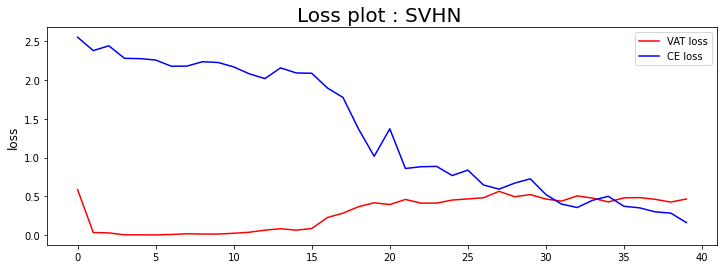

In [10]:
plt.title('Loss plot : SVHN ', fontsize=20) 
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

In [11]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.0625,0.18
1,5,0.9375,0.80
2,9,1.0000,0.84


In [12]:
loss_df.round(4).to_csv('./result/svhn_2_5_acc.csv',index=False)

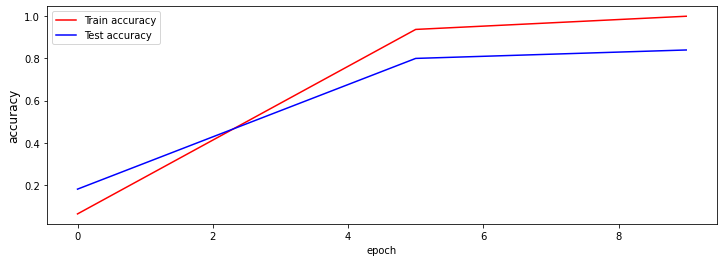

In [13]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

- epsilon = 2

In [14]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', default = 'svhn',  help='cifar10 | svhn')
parser.add_argument('--dataroot', default = './data',  help='path to dataset')
parser.add_argument('--use_cuda', type=bool, default=True)
parser.add_argument('--num_epochs', type=int, default = 10)
parser.add_argument('--epoch_decay_start', type=int, default = 6)
parser.add_argument('--epsilon', type=float, default=2)
parser.add_argument('--top_bn', type=bool, default=True)
parser.add_argument('--method', default='vat')


opt = parser.parse_args([])

In [15]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.7209, device='cuda:0') CE Loss : tensor(3.0919, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.0062, device='cuda:0') CE Loss : tensor(2.2703, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.0034, device='cuda:0') CE Loss : tensor(2.2382, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.0076, device='cuda:0') CE Loss : tensor(2.2392, device='cuda:0')
Train accuracy : tensor(0.1250, device='cuda:0')
Test accuracy : tensor(0.2100, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.0084, device='cuda:0') CE Loss : tensor(2.2650, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.0125, device='cuda:0') CE Loss : tensor(2.2764, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.0117, device='cuda:0') CE Loss : tensor(2.2149, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.0193, device='cuda:0') CE Loss : tensor(2.2505, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.0222, device='cuda:0

In [16]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.round(4).to_csv('./result/svhn_2_loss.csv',index=False)
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.720855,3.091871
1,0,100,0.006155,2.270272
2,0,200,0.003376,2.238249
3,0,300,0.007574,2.239206
4,1,0,0.008372,2.264990


In [17]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.round(4).to_csv('./result/svhn_2_acc.csv',index=False)
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.12500,0.21
1,5,0.96875,0.89
2,9,1.00000,0.89


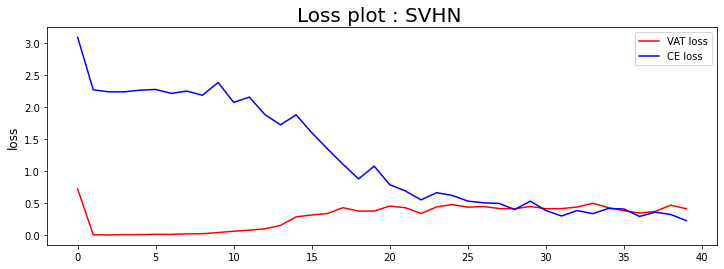

In [18]:
plt.title('Loss plot : SVHN ', fontsize=20)
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

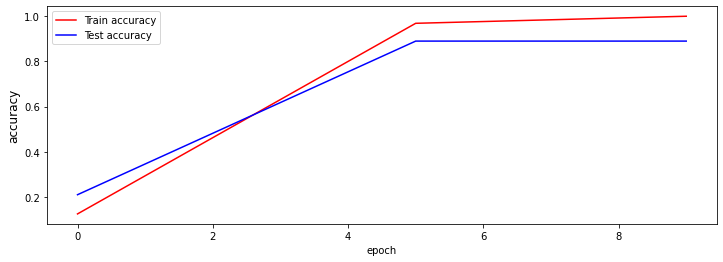

In [19]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

- epsilon = 3

In [20]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', default = 'svhn',  help='cifar10 | svhn')
parser.add_argument('--dataroot', default = './data',  help='path to dataset')
parser.add_argument('--use_cuda', type=bool, default=True)
parser.add_argument('--num_epochs', type=int, default = 10)
parser.add_argument('--epoch_decay_start', type=int, default = 6)
parser.add_argument('--epsilon', type=float, default=3)
parser.add_argument('--top_bn', type=bool, default=True)
parser.add_argument('--method', default='vat')


opt = parser.parse_args([])

In [21]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.6634, device='cuda:0') CE Loss : tensor(2.8780, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.0519, device='cuda:0') CE Loss : tensor(2.8300, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.0030, device='cuda:0') CE Loss : tensor(2.2872, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.0047, device='cuda:0') CE Loss : tensor(2.2624, device='cuda:0')
Train accuracy : tensor(0.2500, device='cuda:0')
Test accuracy : tensor(0.1900, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.0037, device='cuda:0') CE Loss : tensor(2.2771, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.0046, device='cuda:0') CE Loss : tensor(2.2523, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.0047, device='cuda:0') CE Loss : tensor(2.3109, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.0051, device='cuda:0') CE Loss : tensor(2.2066, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.0074, device='cuda:0

In [22]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.round(4).to_csv('./result/svhn_3_loss.csv',index=False)
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.663366,2.878043
1,0,100,0.051889,2.830046
2,0,200,0.002962,2.287237
3,0,300,0.004651,2.262411
4,1,0,0.003711,2.277122


In [23]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.round(4).to_csv('./result/svhn_3_acc.csv',index=False)
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.25000,0.19
1,5,0.78125,0.75
2,9,1.00000,0.90


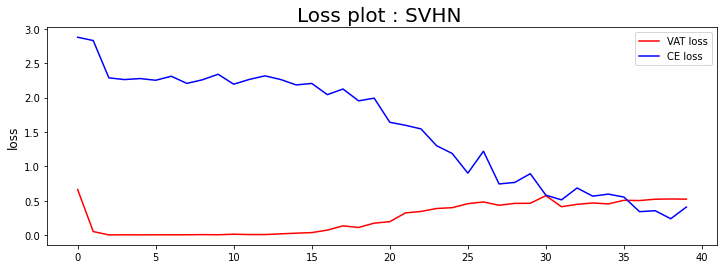

In [24]:
plt.title('Loss plot : SVHN ', fontsize=20)
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

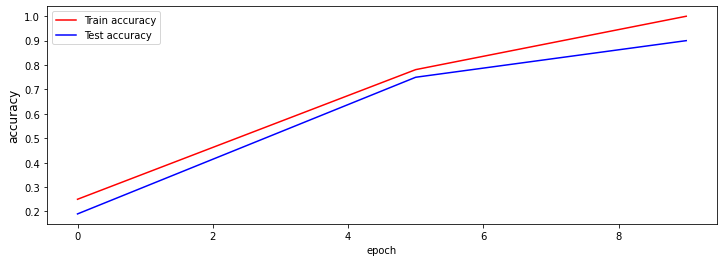

In [25]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

### **Analysis**

|**epsilon**|2.0|2.5|3.0|
|:--:|:--:|:--:|:--:|
|**result**|0.8770|0.8635|0.8883|

- epsilon값의 변화에 따른 test accuracy는 다음과 같았습니다. epsilon값이 3.0으로 설정되었을 때, 가장 test accuracy가 높게 책정되었다는 결과를 확인할 수 있었습니다. 이는 epsilon값이 커지면 perturbation이 좀더 많이 적용된 예시들로 학습이 진행되면서 input에 perturbation이 추가되어도 model의 output에는 큰 변화가 생기지 않는, 즉, 강건한 model을 갖게 될 수 있다는 점을 의미합니다. 위의 경우, perturbation은 adversarial한 방향에 있게 된다는 점을 한번 더 짚고 넘어가면 좋을 것 같습니다.

### **Cifar 10 데이터셋**

In [26]:
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', default = 'cifar10',  help='cifar10 | svhn')
parser.add_argument('--dataroot', default = './data',  help='path to dataset')
parser.add_argument('--use_cuda', type=bool, default=True)
parser.add_argument('--num_epochs', type=int, default = 10)
parser.add_argument('--epoch_decay_start', type=int, default = 6)
parser.add_argument('--epsilon', type=float, default=2.5)
parser.add_argument('--top_bn', type=bool, default=True)
parser.add_argument('--method', default='vat')


opt = parser.parse_args([])

- 라벨 수 = 4000

In [27]:
num_labeled = 4000
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=eval_batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.7324, device='cuda:0') CE Loss : tensor(2.8790, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.1284, device='cuda:0') CE Loss : tensor(1.9536, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.1798, device='cuda:0') CE Loss : tensor(1.9441, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.1277, device='cuda:0') CE Loss : tensor(1.8062, device='cuda:0')
Train accuracy : tensor(0.4688, device='cuda:0')
Test accuracy : tensor(0.3300, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.1298, device='cuda:0') CE Loss : tensor(1.6336, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.1321, device='cuda:0') CE Loss : tensor(1.8114, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.1559, device='cuda:0') CE Loss : tensor(1.4758, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.1560, device='cuda:0') CE Loss : tensor(1.6276, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.1366, device='cuda:0

In [29]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.round(4).to_csv('./result/cifar10_4000_loss.csv',index=False)
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.732393,2.878994
1,0,100,0.128443,1.953575
2,0,200,0.179817,1.944085
3,0,300,0.127739,1.806246
4,1,0,0.129796,1.633604


In [30]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.round(4).to_csv('./result/cifar10_4000_acc.csv',index=False)
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.46875,0.33
1,5,0.62500,0.54
2,9,0.78125,0.56


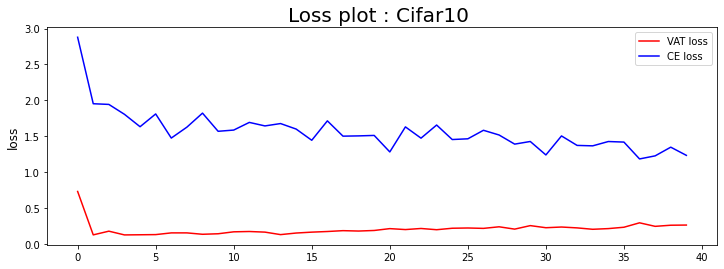

In [31]:
plt.title('Loss plot : Cifar10 ', fontsize=20) 
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

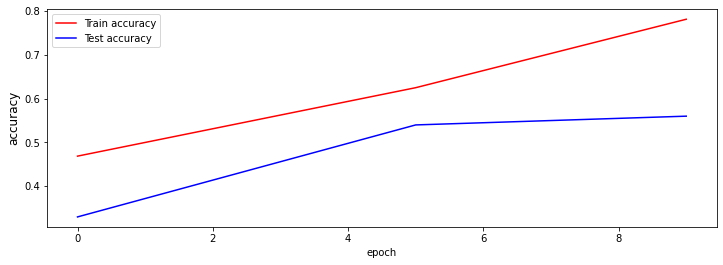

In [32]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

- 라벨 수 = 2000

In [33]:
num_labeled = 2000
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=eval_batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.8176, device='cuda:0') CE Loss : tensor(2.9062, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.1433, device='cuda:0') CE Loss : tensor(2.0185, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.1930, device='cuda:0') CE Loss : tensor(1.7427, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.1424, device='cuda:0') CE Loss : tensor(1.7270, device='cuda:0')
Train accuracy : tensor(0.2812, device='cuda:0')
Test accuracy : tensor(0.4000, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.1712, device='cuda:0') CE Loss : tensor(1.7060, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.1462, device='cuda:0') CE Loss : tensor(1.7229, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.1130, device='cuda:0') CE Loss : tensor(1.5864, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.1475, device='cuda:0') CE Loss : tensor(1.7368, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.1962, device='cuda:0

In [35]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.round(4).to_csv('./result/cifar10_2000_loss.csv',index=False)
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.817554,2.906203
1,0,100,0.143324,2.018546
2,0,200,0.193044,1.742650
3,0,300,0.142422,1.726969
4,1,0,0.171152,1.706032


In [36]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.round(4).to_csv('./result/cifar10_2000_acc.csv',index=False)
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.28125,0.40
1,5,0.65625,0.51
2,9,0.78125,0.56


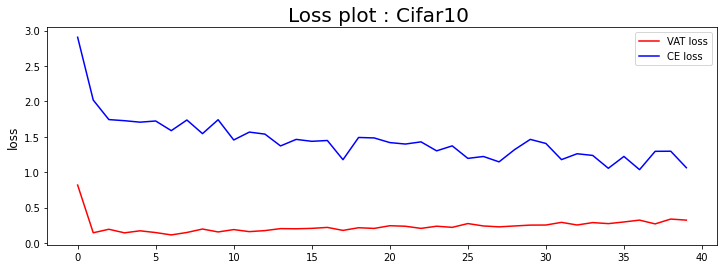

In [37]:
plt.title('Loss plot : Cifar10 ', fontsize=20)
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

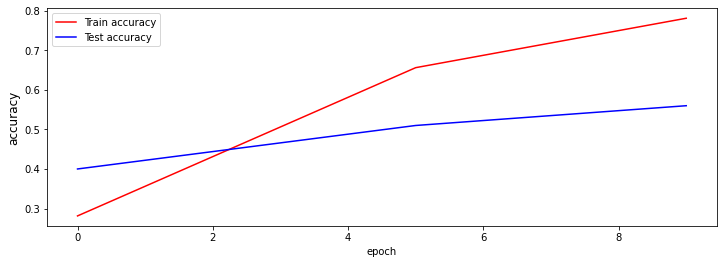

In [38]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

- 라벨 수 = 1000

In [39]:
num_labeled = 1000
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=opt.dataroot, train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=eval_batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
train_data = []
train_target = []

for (data, target) in train_loader:
    train_data.append(data)
    train_target.append(target)

train_data = torch.cat(train_data, dim=0)
train_target = torch.cat(train_target, dim=0)

valid_data, train_data = train_data[:num_valid, ], train_data[num_valid:, ]
valid_target, train_target = train_target[:num_valid], train_target[num_valid:, ]

labeled_train, labeled_target = train_data[:num_labeled, ], train_target[:num_labeled, ]
unlabeled_train = train_data[num_labeled:, ]

model = tocuda(VAT(opt.top_bn))
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_vat_loss = []
train_ce_loss = []
train_epoch = []
train_iter = []

epoch_list = []
train_acc = []
test_acc = []

# train the network
for epoch in range(opt.num_epochs):

    if epoch > opt.epoch_decay_start:
        decayed_lr = (opt.num_epochs - epoch) * lr / (opt.num_epochs - opt.epoch_decay_start)
        optimizer.lr = decayed_lr
        optimizer.betas = (0.5, 0.999)

    for i in range(num_iter_per_epoch):

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        batch_indices_unlabeled = torch.LongTensor(np.random.choice(unlabeled_train.size()[0], unlabeled_batch_size, replace=False))
        ul_x = unlabeled_train[batch_indices_unlabeled]

        v_loss, ce_loss = train(model.train(), Variable(tocuda(x)), Variable(tocuda(y)), Variable(tocuda(ul_x)),
                                optimizer)

        if i % 100 == 0:
            print("Epoch :", epoch, "Iter :", i, "VAT Loss :", v_loss.data, "CE Loss :", ce_loss.data)
            train_epoch.append(epoch)
            train_iter.append(i)
            train_vat_loss.append(v_loss.data.item())
            train_ce_loss.append(ce_loss.data.item())

    if epoch % eval_freq == 0 or epoch + 1 == opt.num_epochs:
        
        epoch_list.append(epoch)

        batch_indices = torch.LongTensor(np.random.choice(labeled_train.size()[0], batch_size, replace=False))
        x = labeled_train[batch_indices]
        y = labeled_target[batch_indices]
        train_accuracy = eval(model.eval(), Variable(tocuda(x)), Variable(tocuda(y)))
        print("Train accuracy :", train_accuracy.data)
        train_acc.append(train_accuracy.data.item())

        for (data, target) in test_loader:
            test_accuracy = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
            print("Test accuracy :", test_accuracy.data)
            test_acc.append(test_accuracy.data.item())
            break


test_accuracy = 0.0
counter = 0
for (data, target) in test_loader:
    n = data.size()[0]
    acc = eval(model.eval(), Variable(tocuda(data)), Variable(tocuda(target)))
    test_accuracy += n*acc
    counter += n

print("Full test accuracy :", test_accuracy.data/counter)

Epoch : 0 Iter : 0 VAT Loss : tensor(0.7073, device='cuda:0') CE Loss : tensor(2.6236, device='cuda:0')
Epoch : 0 Iter : 100 VAT Loss : tensor(0.1379, device='cuda:0') CE Loss : tensor(1.9734, device='cuda:0')
Epoch : 0 Iter : 200 VAT Loss : tensor(0.1141, device='cuda:0') CE Loss : tensor(1.8411, device='cuda:0')
Epoch : 0 Iter : 300 VAT Loss : tensor(0.1358, device='cuda:0') CE Loss : tensor(1.6626, device='cuda:0')
Train accuracy : tensor(0.4688, device='cuda:0')
Test accuracy : tensor(0.3600, device='cuda:0')
Epoch : 1 Iter : 0 VAT Loss : tensor(0.1358, device='cuda:0') CE Loss : tensor(1.6673, device='cuda:0')
Epoch : 1 Iter : 100 VAT Loss : tensor(0.1425, device='cuda:0') CE Loss : tensor(1.7105, device='cuda:0')
Epoch : 1 Iter : 200 VAT Loss : tensor(0.1835, device='cuda:0') CE Loss : tensor(1.7555, device='cuda:0')
Epoch : 1 Iter : 300 VAT Loss : tensor(0.1649, device='cuda:0') CE Loss : tensor(1.5621, device='cuda:0')
Epoch : 2 Iter : 0 VAT Loss : tensor(0.1766, device='cuda:0

In [41]:
train_loss_df = pd.DataFrame({'epoch': train_epoch, 'iteration': train_iter, 'vat_loss': train_vat_loss, 'train_ce_loss': train_ce_loss})
train_loss_df.round(4).to_csv('./result/cifar10_1000_loss.csv',index=False)
train_loss_df.head()

,epoch,iteration,vat_loss,train_ce_loss
0,0,0,0.707334,2.623639
1,0,100,0.137900,1.973405
2,0,200,0.114106,1.841077
3,0,300,0.135799,1.662609
4,1,0,0.135783,1.667272


In [42]:
loss_df = pd.DataFrame({'epoch' : epoch_list, 'train_acc' : train_acc, 'test_acc' : test_acc})
loss_df.round(4).to_csv('./result/cifar10_1000_acc.csv',index=False)
loss_df.head()

,epoch,train_acc,test_acc
0,0,0.46875,0.36
1,5,0.75000,0.52
2,9,1.00000,0.55


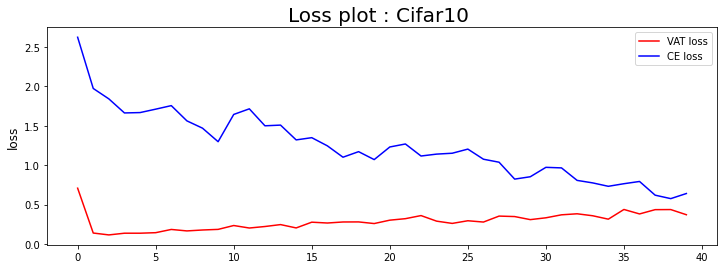

In [43]:
plt.title('Loss plot : Cifar10 ', fontsize=20)
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'vat_loss', color= 'r')
p = sns.lineplot(data = train_loss_df, x = train_loss_df.index, y = 'train_ce_loss', color = 'b')
p.set_ylabel('loss', fontsize = 12)
plt.legend(labels=["VAT loss","CE loss"])

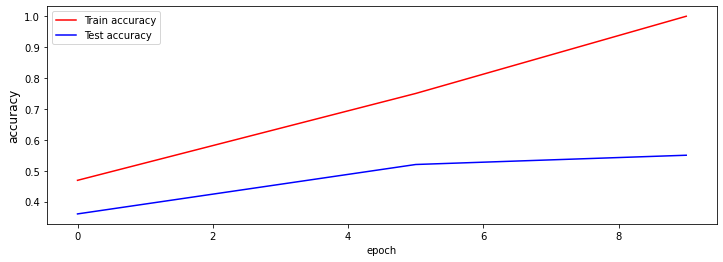

In [44]:
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'train_acc', color= 'r')
p = sns.lineplot(data = loss_df, x = 'epoch', y = 'test_acc', color = 'b')
p.set_ylabel('accuracy', fontsize = 12)
plt.legend(labels=["Train accuracy","Test accuracy"])

### **Analysis**

labels : 훈련에 사용되는 label 데이터 수

|**labels**|1000|2000|4000|
|:--:|:--:|:--:|:--:|
|**accuracy**|0.5148|0.5456|0.5745|

label 수를 각각 1000, 2000, 4000으로 설정하였을 떄, label 수가 증가할수록 성능이 점차 향상되는 모습을 확인할 수 있었습니다. 이는 학습에 있어 label 데이터의 확보가 중요하다는 점을 의미하며 특히 두가지 loss function 중 cross entropy loss와 연관이 되어 있어 결론적으로 전체 성능에 영향을 준다는 점을 확인할 수 있었습니다.